# Clasificador binario con RandomForest del tipo de violencia "abuso y violencia".

Se tienen dos tipos "no tuvo violencia" y "abuso y violencia. Este último incluye a los de la categoría "ambos".

Sin preprocesamiento en el dataset. Todas las columnas se tratan como continuas aunque sean categóricas.

https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=forest#sklearn.ensemble.RandomForestClassifier

In [1]:
# Custom functions
# ==============================================================================
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, InsertarColumnaNueva

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import ParameterGrid, KFold
from chefboost import Chefboost as chef
from sklearn.model_selection import train_test_split

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
def escalar(df, scal):
    ind = df.index
    retail_scaler = pd.DataFrame(scal.fit_transform(df), index=ind)
    retail_scaler.columns = df.columns
    return retail_scaler, scal

In [4]:
def grid(param_grid, X, y, cv=5):
    resultados = {'params': [], 'f1': [], 'cm': []}
    importances = []
    kf = KFold(n_splits=cv, shuffle=True)
    
    for i,params in enumerate(param_grid):
        f1 = []
        cm = []

        for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            modelo = RandomForestClassifier(
                        n_jobs       = -1,
                        ** params
                     )

            modelo.fit(X_train, y_train)

            y_pred = modelo.predict(X_test)
            
            importances.append(modelo.feature_importances_)
            
            f1.append(f1_score(y_test, y_pred))
            cm.append(confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel())
            
        resultados['params'].append(params)
        resultados['f1'].append(max(f1))
        resultados['cm'].append(cm[f1.index(max(f1))])
        
        if i%300 == 0 or i==len(param_grid):
            print(f"Modelo {i}, f1({max(f1)}): {params} \u2713")
    
    #hacer dataset con resultados
    resultados = pd.DataFrame(resultados)
    resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
    resultados = resultados.drop(columns = 'params')
    
    return resultados, importances

## Cargar datos

In [5]:
endireh = CargarPandasDatasetCategoricos('datasets/endireh.csv')

## Preprocesamiento


Solo nos quedamos con las que sufieron 'Abuso y violencia'.

Eliminando los de atención no autorizada

In [6]:
endireh.drop(endireh[endireh["P9_8"]==2].index, axis=0, inplace=True)

'abuso y violencia' y ambos sean 1.

In [7]:
endireh.loc[endireh["P9_8"]>0, "P9_8"] = 1

In [8]:
endireh.shape

(17485, 49)

Ninguno(0):	71%
Abuso y violencia(1):	29%


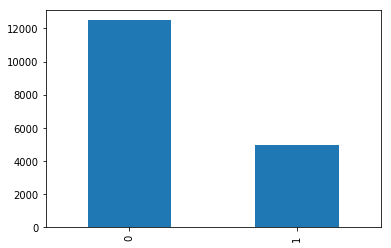

In [9]:
for i,j in zip(['Ninguno(0)', 'Abuso y violencia(1)'], endireh["P9_8"].value_counts()/endireh["P9_8"].value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
endireh["P9_8"].value_counts().plot(kind='bar')

Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [10]:
endireh.drop(columns=['REGION'], inplace=True)
#endireh.drop(columns=['P9_8', 'REGION'], inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(endireh, y, test_size=0.33, random_state=5)

Obtengo la variable objetivo y obtengo el dataset X borrando P9_8.

In [11]:
y = endireh['P9_8'].copy()

In [12]:
X = endireh.drop(columns=['P9_8'], inplace=False)

In [20]:
endireh.loc[endireh["P9_8"]==0, "P9_8"] = 'No'
endireh.loc[endireh["P9_8"]==1, "P9_8"] = 'Si'

In [21]:
X_train, X_test = train_test_split(endireh, test_size=0.2, random_state=5, stratify=endireh['P9_8'])

## Encontrar los mejores parámetros con _Random Forest_

In [13]:
param_grid = ParameterGrid(
                {
                 'max_features'      : ['auto', 'sqrt', 'log2'],
                 'criterion'         : ['gini', 'entropy'],
                 'warm_start'        : [True, False],
                 'bootstrap'         : [True, False],
                 'min_samples_split' : range(285, 580, 25),
                 'min_samples_leaf'  : range(150, 200, 2),
                 'random_state'      : [5],
                }
            )


In [14]:
print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()))

Current Time is : 08:40:07


In [15]:
%time resultados, importances = grid(param_grid, X, y)

Modelo 0, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 300, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_start': True} ✓
Modelo 600, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 900, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_start': True} ✓
Modelo 1200, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 1500, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 174,

In [16]:
print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()))

Current Time is : 14:18:02


In [17]:
resultados.sort_values(by=['f1'], ascending=False).head(5)

,f1,cm,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split,random_state,warm_start
0,0.0,"[2507, 0, 990, 0]",True,gini,auto,150,285,5,True
4837,0.0,"[2515, 0, 982, 0]",False,gini,log2,152,435,5,False
4807,0.0,"[2513, 0, 984, 0]",False,gini,log2,150,360,5,False
4806,0.0,"[2503, 0, 994, 0]",False,gini,log2,150,360,5,True
4805,0.0,"[2476, 0, 1021, 0]",False,gini,log2,150,335,5,False


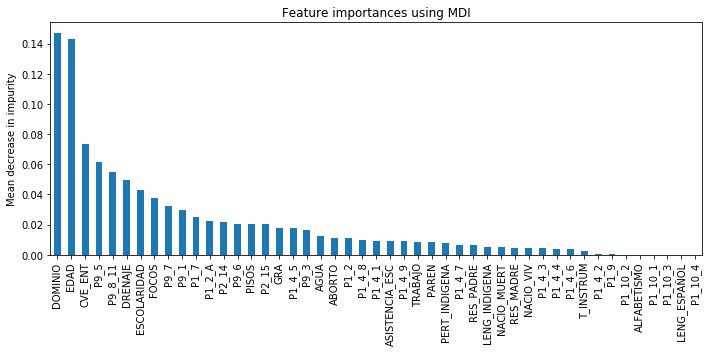

In [18]:
forest_importances = pd.Series(np.mean(importances, axis = 0), index=X.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
#forest_importances[:15].plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Encontrar los mejores parámetros con _Chefboost_

https://towardsdatascience.com/chefboost-an-alternative-python-library-for-tree-based-models-f46af028a348

https://github.com/serengil/chefboost

https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/

https://sefiks.com/2019/08/31/a-begineers-guide-to-decision-trees-in-python/


### ID3

In [41]:
config = {'algorithm':'ID3', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
ID3  tree is going to be built...
-------------------------
finished in  1832.790983915329  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[3997, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 30min 27s, sys: 6.05 s, total: 30min 33s
Wall time: 30min 33s


In [42]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  59.050614812696594 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[314, 747], [685, 1751]]
Precision:  29.5947 %, Recall:  31.4314 %, F1:  30.4854 %


### C4.5

In [43]:
config = {'algorithm':'C4.5', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  1950.3161001205444  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[3997, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 31min 49s, sys: 41.8 s, total: 32min 31s
Wall time: 32min 31s


In [44]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  58.707463540177294 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[337, 782], [662, 1716]]
Precision:  30.1162 %, Recall:  33.7337 %, F1:  31.8225 %


### CHAID

In [45]:
config = {'algorithm':'CHAID', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  2631.346908092499  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[3997, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 43min 44s, sys: 7.13 s, total: 43min 51s
Wall time: 43min 52s


In [46]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  59.87989705461825 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[325, 729], [674, 1769]]
Precision:  30.8349 %, Recall:  32.5325 %, F1:  31.661 %


### enableGBM

In [47]:
config = {'enableGBM': True, 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Boosting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO]:  -1 CPU cores will be allocated in parallel running
Gradient Boosting Machines...
Regression  tree is going to be built...
gradient boosting for classification


Epoch 10. Accuracy: 93. Process: : 100%|██████████| 10/10 [5:10:48<00:00, 1864.82s/it]


The best accuracy got in  9  epoch with the score  93.73748927652274
-------------------------
finished in  18648.24024605751  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  93.53731770088648 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[3334, 241], [663, 9750]]
Precision:  93.2587 %, Recall:  83.4126 %, F1:  88.0613 %


CPU times: user 5h 9min 40s, sys: 1min 4s, total: 5h 10min 44s
Wall time: 5h 10min 50s


In [48]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  62.7680869316557 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[288, 591], [711, 1907]]
Precision:  32.7645 %, Recall:  28.8288 %, F1:  30.6709 %


### enableRandomForest 100

In [49]:
config = {'enableRandomForest':True, 'num_of_trees':100, 'algorithm':'CART', 'enableParallelism':True, 'num_cores': 8, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Sub decision tree 100 is processing: 100%|██████████| 100/100 [00:00<00:00, 784.95it/s]

[INFO]:  8 CPU cores will be allocated in parallel running
CART  tree is going to be built...



100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


-------------------------
finished in  114.6425850391388  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.46125250214469 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[9, 4], [3988, 9987]]
Precision:  69.2308 %, Recall:  0.2252 %, F1:  0.4489 %


CPU times: user 4.18 s, sys: 161 ms, total: 4.34 s
Wall time: 1min 58s


In [50]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  71.37546468401487 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[0, 2], [999, 2496]]
Precision:  0.0 %, Recall:  0.0 %, F1:  0.0 %


### enableRandomForest 5

In [51]:
config = {'enableRandomForest':True, 'num_of_trees':5, 'algorithm':'CART', 'enableParallelism':True, 'num_cores': 8, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Sub decision tree 5 is processing: 100%|██████████| 5/5 [00:00<00:00, 222.14it/s]

[INFO]:  8 CPU cores will be allocated in parallel running
CART  tree is going to be built...



100%|██████████| 5/5 [02:59<00:00, 35.94s/it] 


-------------------------
finished in  179.88167428970337  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.58621675722047 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[1612, 1030], [2385, 8961]]
Precision:  61.0144 %, Recall:  40.3302 %, F1:  48.5615 %


CPU times: user 2.1 s, sys: 101 ms, total: 2.2 s
Wall time: 3min 1s


In [52]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  65.54189305118673 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[215, 421], [784, 2077]]
Precision:  33.805 %, Recall:  21.5215 %, F1:  26.2997 %


### CART

In [53]:
config = {'algorithm':'CART', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CART  tree is going to be built...
-------------------------
finished in  1612.2431542873383  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  13988  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[3997, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 26min 46s, sys: 6.61 s, total: 26min 52s
Wall time: 26min 53s


In [54]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  60.56619959965685 % on  3497  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[352, 732], [647, 1766]]
Precision:  32.4723 %, Recall:  35.2352 %, F1:  33.7974 %


### Feature importance

Decision rule:  outputs/rules/rules.py


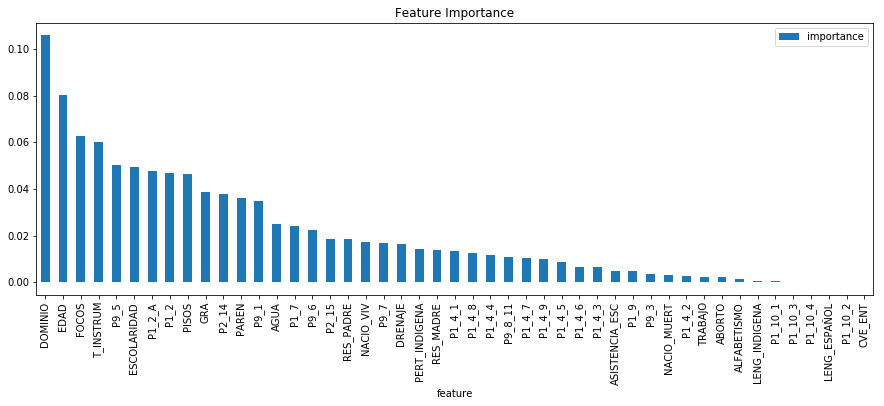

In [55]:
fi = chef.feature_importance("outputs/rules/rules.py")
fi.set_index('feature').plot.bar(title="Feature Importance", figsize=(15,5))